In [235]:
import yfinance as yf
from apify_client import ApifyClient
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Fetch Stock Data

In [285]:
def get_stocksData(tickers_name, start_date= None):
    global df_finalStock
    df_finalStock= pd.DataFrame()

    for index,stock in enumerate(tickers_name):
        ticker= yf.Ticker(stock)
        ticker_stock = ticker.history(period='1mo', start= pd.to_datetime(start_date))
        ticker_stock['day']= ticker_stock.index.day
        ticker_stock['month']= ticker_stock.index.month
        ticker_stock['year']= ticker_stock.index.year
        ticker_stock['dateTime']= pd.to_datetime(ticker_stock[['year', 'month', 'day']])
        ticker_stock= ticker_stock.set_index(keys='dateTime')
        ticker_stock= ticker_stock[['Close']]
        ticker_stock.columns= [stock]
        ticker_stock= pd.DataFrame(ticker_stock)    

        if index == 0:
            df_finalStock= pd.DataFrame(ticker_stock)
        else:
            df_finalStock= pd.merge(df_finalStock, ticker_stock, left_index= True, right_index= True)
                    
    
    


# Fetch Trends Data

In [238]:
def get_trendsData(keywords ,API_TOKEN= 'apify_api_EvEL4Oawoze0LxkvZ831rW4SQYunIv1Iku30'):    
    global df_finalTrends
    client = ApifyClient(API_TOKEN)
    df_finalTrends = pd.DataFrame()

    for j, trend in enumerate(keywords):
        run_input = {
            "searchTerms": [trend],
            "isMultiple": False,
            "timeRange": "today 1-m",
            "geo": "",
            "viewedFrom": "id",
            "skipDebugScreen": False,
            "isPublic": False,
            "category": "",
            "maxItems": 0,
            "extendOutputFunction": """($) => {
            const result = {};

            return result;
        }""",
            "outputAsISODate": True,
            "csvOutput": False,
            "maxConcurrency": 10,
            "maxRequestRetries": 15,
            "pageLoadTimeoutSecs": 180,
        }

        run = client.actor("DyNQEYDj9awfGQf9A").call(run_input=run_input)

        items_list = []

        for item in client.dataset(run["defaultDatasetId"]).iterate_items():
            row = {}
            for key, value in item.items():
                row['Key'] = key
                row['Value'] = value
                items_list.append(row.copy())

        df_trend = pd.DataFrame(items_list)
        df_trend.columns = df_trend.iloc[0]
        df_trend = df_trend[1:]
        df_trend = df_trend.reset_index(drop=True)

        df_trend['Term / Date'] = pd.to_datetime(df_trend['Term / Date'])
        df_trend['day'] = df_trend['Term / Date'].dt.day
        df_trend['month'] = df_trend['Term / Date'].dt.month
        df_trend['year'] = df_trend['Term / Date'].dt.year
        df_trend['datetime'] = pd.to_datetime(df_trend[['year', 'month', 'day']])
        df_trend = df_trend.set_index('datetime')
        df_trend = df_trend[[trend]]

        if j == 0:
            df_finalTrends = df_trend
        else:
            df_finalTrends = pd.merge(df_finalTrends, df_trend, left_index=True, right_index=True)



# Transformation

In [277]:
def merging_Datasets(dataFrame1, dataFrame2):
    global merged_dataFrame
    merged_dataFrame= pd.merge(dataFrame1, dataFrame2, left_index=True, right_index= True)

    for col in merged_dataFrame.columns:
        merged_dataFrame[col]= merged_dataFrame[col].astype('float64')

    scaler = MinMaxScaler(feature_range= (0,100))
    merged_dataFrame[merged_dataFrame.columns]= scaler.fit_transform(merged_dataFrame[merged_dataFrame.columns])
    

In [ ]:
kataKunci = ['israel', 'boikot']

get_trendsData(keywords= kataKunci)

In [287]:
tickers= ['MAPI.JK', 'MAPB.JK','FAST.JK']

get_stocksData(tickers, '2023-09-01')
df_finalStock.head()

,MAPI.JK,MAPB.JK,FAST.JK
dateTime,,,
2023-09-01,1975.0,2140.0,810.0
2023-09-04,1980.0,2100.0,810.0
2023-09-05,1960.0,2090.0,810.0
2023-09-06,1900.0,2090.0,810.0
2023-09-07,1840.0,2090.0,810.0


In [296]:
merging_Datasets(df_finalStock,df_finalTrends)
df_finalStock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2023-09-01 to 2023-11-28
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MAPI.JK  62 non-null     float64
 1   MAPB.JK  62 non-null     float64
 2   FAST.JK  62 non-null     float64
dtypes: float64(3)
memory usage: 4.0 KB


In [297]:
df_finalStock.head()

,MAPI.JK,MAPB.JK,FAST.JK
dateTime,,,
2023-09-01,1975.0,2140.0,810.0
2023-09-04,1980.0,2100.0,810.0
2023-09-05,1960.0,2090.0,810.0
2023-09-06,1900.0,2090.0,810.0
2023-09-07,1840.0,2090.0,810.0


<Axes: xlabel='dateTime'>

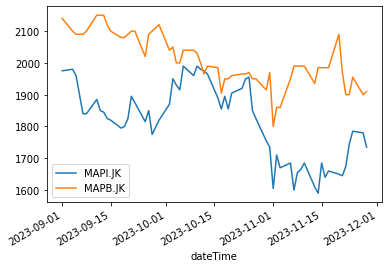

In [295]:

df_finalStock[['MAPI.JK', 'MAPB.JK']].plot()

In [281]:
merged_dataFrame.corr()

,MAPI.JK,MAPB.JK,FAST.JK,israel,boikot
MAPI.JK,1.000000,-0.124893,0.467118,-0.084140,-0.461185
MAPB.JK,-0.124893,1.000000,-0.310445,-0.444682,0.173803
FAST.JK,0.467118,-0.310445,1.000000,0.243156,-0.264995
israel,-0.084140,-0.444682,0.243156,1.000000,-0.103479
boikot,-0.461185,0.173803,-0.264995,-0.103479,1.000000
